In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from skimage import io
from itertools import chain
from skimage.io import imread,imshow
import matplotlib.image as mpimg #read png files
from scipy.ndimage import gaussian_filter
import scipy

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

# Load data from NIH clinical center

In [2]:
!ls -l /data

total 19348
-rw-r--r-- 1 root root 8963138 Sep 25  2019 ARXIV_V5_CHESTXRAY.pdf
-rw-r--r-- 1 root root   92416 Sep 25  2019 BBox_List_2017.csv
-rw-r--r-- 1 root root 7861152 Sep 25  2019 Data_Entry_2017.csv
-rw-r--r-- 1 root root   72223 Sep 25  2019 FAQ_CHESTXRAY.pdf
drwxr-xr-x 3 root root    4096 Feb 28  2020 images_001
drwxr-xr-x 3 root root    4096 Feb 28  2020 images_002
drwxr-xr-x 3 root root    4096 Feb 28  2020 images_003
drwxr-xr-x 3 root root    4096 Feb 28  2020 images_004
drwxr-xr-x 3 root root    4096 Feb 28  2020 images_005
drwxr-xr-x 3 root root    4096 Feb 28  2020 images_006
drwxr-xr-x 3 root root    4096 Feb 28  2020 images_007
drwxr-xr-x 3 root root    4096 Feb 28  2020 images_008
drwxr-xr-x 3 root root    4096 Feb 28  2020 images_009
drwxr-xr-x 3 root root    4096 Feb 28  2020 images_010
drwxr-xr-x 3 root root    4096 Feb 28  2020 images_011
drwxr-xr-x 3 root root    4096 Feb 28  2020 images_012
-rw-r--r-- 1 root root    3919 Sep 25  2019 LOG_CHESTXRAY.pdf
-rw-r--r--

In [3]:
pd.set_option('display.max_columns', None)
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
3620,00017827_000.png,No Finding,0,17827,012Y,M,AP,3056,2544,0.139,0.139
4851,00025505_001.png,Mass,1,25505,044Y,M,PA,2892,2991,0.143,0.143
4539,00022684_006.png,No Finding,6,22684,045Y,M,PA,2992,2991,0.143,0.143


### Data Cleaning: Split 'Finding Labels' to multiple Flag 0/1 column for each disease

In [4]:
labels=np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
labels=[x for x in labels if len(x)>0]
print(labels)

for label in labels:
        all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda x: 1.0 if label in x else 0)

all_xray_df.head(3)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
labels=np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
labels=[x for x in labels if len(x)>0]
print(labels)

for label in labels:
        sample_df[label] = sample_df['Finding Labels'].map(lambda x: 1.0 if label in x else 0)

sample_df.head(3)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [6]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
 12  Atelectasis                  112120 non-null  float64
 13 

# Demographics

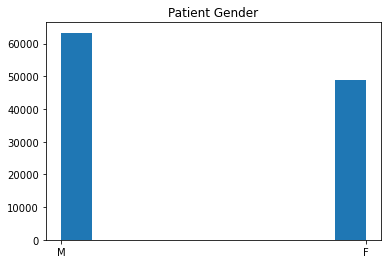

In [7]:
#Gender distribution
plt.hist(all_xray_df['Patient Gender'])
plt.title('Patient Gender')
plt.show()

Patient gender: a slight imbalance between Males (56%) and Females (44%) in the dataset

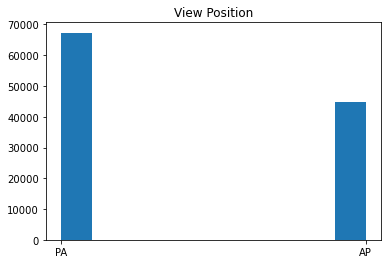

In [8]:
#Patient Position
plt.hist(all_xray_df['View Position'])
plt.title('View Position')
plt.show()

The X-ray views taken at the patient position show that PA views account for 60%, while AP views make up 40%

In [9]:
#Number of Pneumonia cases and Non-Pneumonia Cases
Pneu=all_xray_df[all_xray_df['Pneumonia']==1]
NonPneu=all_xray_df[all_xray_df['Pneumonia']==0]
print('Total Pneumonia cases: {}'.format(len(Pneu)))
print('Total Non-Pneumonia cases: {}'.format(len(NonPneu)))
print('% of pneumonia cases is {}%'.format(np.round(100*len(Pneu)/(len(Pneu)+len(NonPneu)), 2)))

Total Pneumonia cases: 1431
Total Non-Pneumonia cases: 110689
% of pneumonia cases is 1.28%


In [10]:
print('Top 10 Comorbidities with pneumonia: \n{}'.format(Pneu['Finding Labels'].value_counts()[0:10]))

Top 10 Comorbidities with pneumonia: 
Pneumonia                             322
Infiltration|Pneumonia                199
Edema|Infiltration|Pneumonia          137
Atelectasis|Pneumonia                 108
Edema|Pneumonia                        83
Effusion|Pneumonia                     54
Effusion|Infiltration|Pneumonia        42
Consolidation|Pneumonia                36
Atelectasis|Infiltration|Pneumonia     34
Atelectasis|Effusion|Pneumonia         23
Name: Finding Labels, dtype: int64


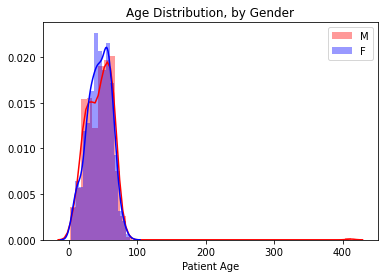

In [11]:
#Age Distribution of Pneumonia Patients, by Gender
sns.distplot(Pneu['Patient Age'][Pneu['Patient Gender']=='M'],color='red', label='M')
sns.distplot(Pneu['Patient Age'][Pneu['Patient Gender']=='F'],color='blue', label='F')
plt.title('Age Distribution, by Gender')
# plt.xlim(0,120)
plt.legend()

There are outliers among patients aged over 100 years. The ages of these patients—148, 149, 150, 151, 152, 153, 154, 155, 411, 412, 413, and 414—are not meaningful. When building our models, it's important to remove these outliers.

# Number of disease per patient

In [12]:
sum_disease_pts = all_xray_df.groupby(['Patient ID'])[list(labels)].sum()

for col in labels:
    sum_disease_pts[col] = sum_disease_pts[col].apply(lambda x: 1 if x != 0 else 0)
sum_disease_pts['sum_diseases'] = sum_disease_pts.sum(axis=1)

sum_disease_pts['sum_diseases'].value_counts().sort_index()/len(sum_disease_pts)

1     0.656517
2     0.134459
3     0.069826
4     0.044181
5     0.033274
6     0.020484
7     0.015842
8     0.010518
9     0.006492
10    0.004447
11    0.002694
12    0.000909
13    0.000227
14    0.000130
Name: sum_diseases, dtype: float64

The majority of patients (65%) have records of only one unique disease, while a smaller portion (13%) have records of two unique diseases. Very few patients have three or more unique disease records.

# Distribution of other diseases that are comorbid with pneumonia

In [13]:
total_patients = len(sum_disease_pts)
pneumonia_patients = len(sum_disease_pts[sum_disease_pts['Pneumonia'] == 1])
only_pneumonia_patients = len(sum_disease_pts[sum_disease_pts.drop(['Pneumonia', 'sum_diseases'], axis=1).sum(axis=1) == 0])

print(total_patients, "unique patients,", pneumonia_patients, "patients have pneumonia.")
print("Out of these pneumonia patients, there are", only_pneumonia_patients, "unique patients who have only pneumonia and no other disease.")


30805 unique patients, 1008 patients have pneumonia.
Out of these pneumonia patients, there are 27 unique patients who have only pneumonia and no other disease.


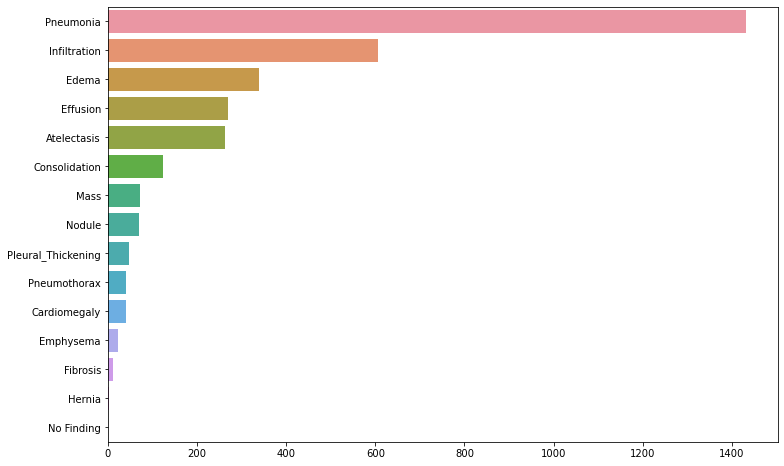

In [14]:
df_pneu = all_xray_df[all_xray_df['Pneumonia'] == 1]

plt.rcParams["figure.figsize"] = (12,8)
sr_labels_count = df_pneu[labels].sum().sort_values(ascending=False)
ax = sns.barplot(x=sr_labels_count.values, y=sr_labels_count.index)

The most common diseases that co-occur with pneumonia are: Infiltration, Edema, Effusion, and Atelectasis

# Pixel Level Assessments

In [15]:
sample_df['sum_diseases'] = sample_df.iloc[:,11:].sum(axis=1)

# Find image paths for png listed
img_paths = {os.path.basename(c): c for c in glob(os.path.join('/data','images*', '*', '*.png'))}
sample_df['img_path'] = sample_df['Image Index'].map(img_paths.get)

## Random image samples with labels

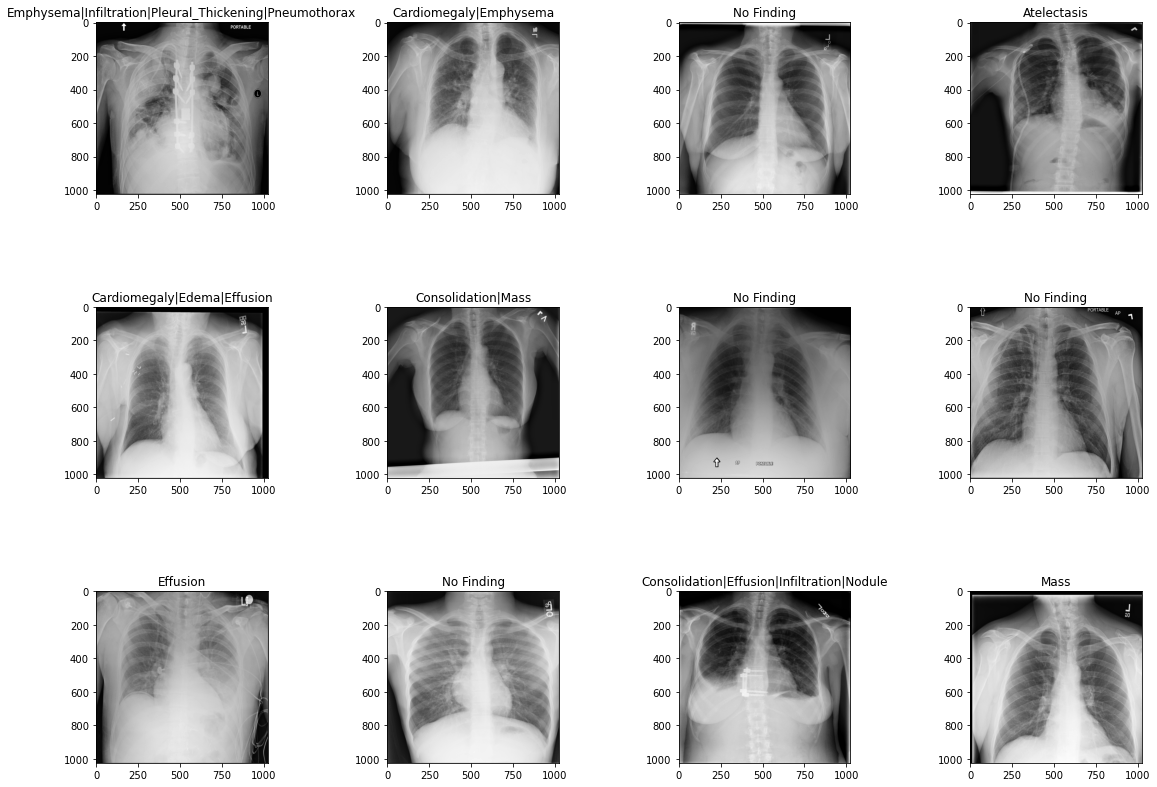

In [16]:
# Define the number of rows and columns
rows = 3
cols = 4

# Create a grid of images
fig, m_axs = plt.subplots(rows, cols, figsize=(16, 12))
m_axs = m_axs.flatten()  # Flatten the image grid

# Sample a subset of image paths from the sample dataframe
imgs = sample_df.sample(rows * cols).img_path

ind = 0  # Initialize the image index to 0

# Iterate over each image path and its corresponding subplot
for img, ax in zip(imgs, m_axs):
    # Read the image
    img = io.imread(img)
    
    # Display the image
    ax.imshow(img, cmap='gray')
    
    # Set the subplot title to the label of the image
    ax.set_title(sample_df.iloc[ind]['Finding Labels'])
    
    ind += 1  # Increment the image index

plt.tight_layout()
plt.show()


## only-pneumonia image samples

In [17]:
# only pneumonia case
sample_df_pneu = sample_df[(sample_df["Pneumonia"] == 1) & (sample_df["sum_diseases"] == 1)]
sample_df_pneu.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,sum_diseases,img_path
1631,00008470_008.png,Pneumonia,8,8470,030Y,F,AP,2500,2048,0.171,0.171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,/data/images_004/images/00008470_008.png
2286,00011702_043.png,Pneumonia,43,11702,026Y,F,AP,2500,2048,0.168,0.168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,/data/images_006/images/00011702_043.png
2422,00012158_025.png,Pneumonia,25,12158,047Y,F,PA,2992,2991,0.143,0.143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,/data/images_006/images/00012158_025.png
2522,00012667_000.png,Pneumonia,0,12667,007Y,F,PA,1804,1685,0.143,0.143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,/data/images_006/images/00012667_000.png
2534,00012733_000.png,Pneumonia,0,12733,073Y,M,PA,2992,2991,0.143,0.143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,/data/images_006/images/00012733_000.png


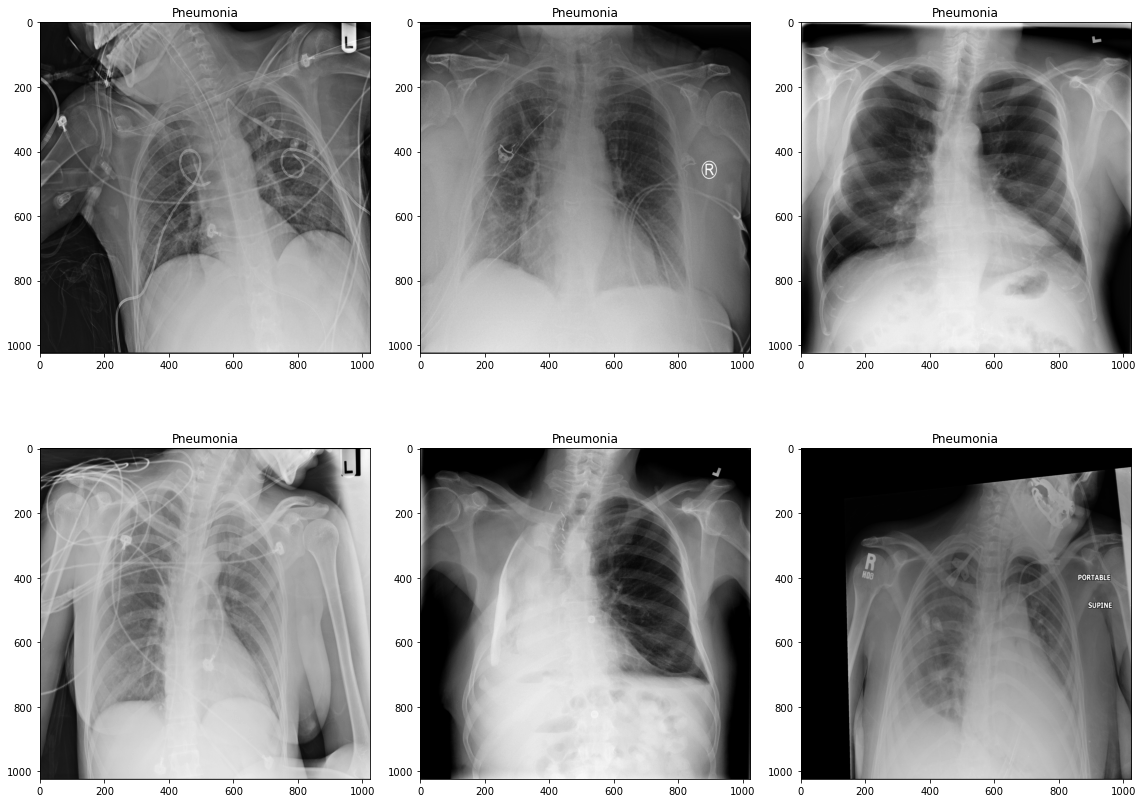

In [18]:
rows=2
cols=3

fig, m_axs = plt.subplots(rows,cols, figsize = (16, 12))
m_axs = m_axs.flatten()
imgs = sample_df_pneu.sample(rows*cols).img_path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    ax.set_title(sample_df_pneu.iloc[ind]['Finding Labels'])
    ind=ind+1
    
plt.tight_layout()

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
sample_df_pneu['img_data'] = sample_df_pneu.apply(lambda x: io.imread(x['img_path']), axis=1).copy()

In [21]:
def get_dist_plot(df_col):
    ax = sns.distplot(df_col, rug=True)
    try:
        ax.set_xlim(0,df_col.max())
    except:
        None
    plt.show()

def image_intensity(img_data, bg_th):
    mask = img_data > bg_th
    f = plt.figure(figsize = (16, 5))

    s1 = f.add_subplot(1, 3, 1)
    s1.set_title('Image')
    plt.imshow(img_data, cmap='gray')

    s2 = f.add_subplot(1, 3, 2)
    s2.set_title('Mask')
    plt.imshow(mask.astype(int)*255, cmap='gray')
    
    s3 = f.add_subplot(1, 3, 3)
    s3.set_title('Intensity Distribution')
    get_dist_plot(img_data[mask])

    plt.show()

# Pneumonia Image - Mask - Intensity distribution 

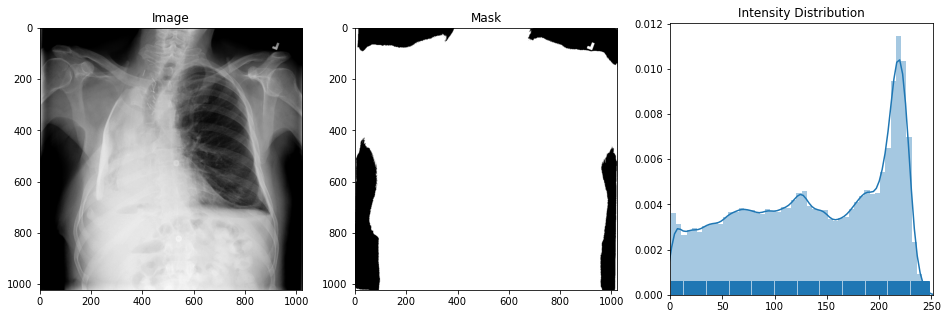

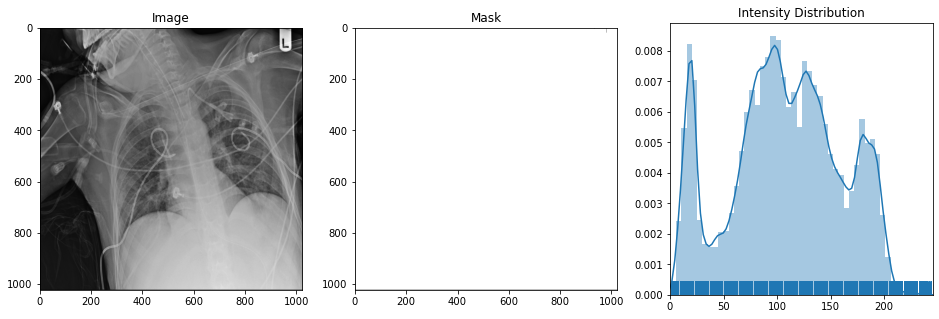

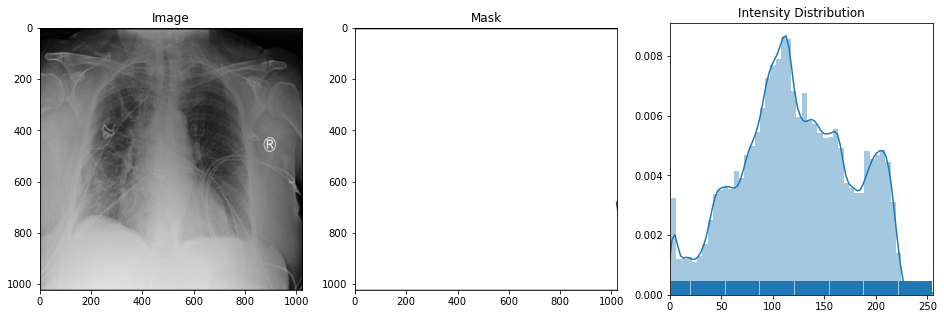

In [22]:
for img in sample_df_pneu.sample(3).img_data.values:
    image_intensity(img, 0.1)

In [23]:
def normalize_img(pixel_array):
    mean_intensity = np.mean(pixel_array)
    std_intensity = np.std(pixel_array)
    return (pixel_array.copy() - mean_intensity)/std_intensity

def get_intensities(label, bg_th):
    # Get paths of images where the specified label is present
    paths = list(sample_df[sample_df[label]==1]['img_path'].values)
    
    # Initialize an empty list to store intensities
    pneu_int = []
    
    # Loop through each image path
    for path in paths:
        # Read and normalize the image
        img = normalize_img(io.imread(path))
        
        # Create a mask to identify pixels above the background threshold
        mask = img > bg_th
        
        # Flatten and extend the intensities list with intensities of pixels above background threshold
        pneu_int.extend(img[mask].flatten().tolist())
    
    # Return the list of intensities
        return pneu_int


In [24]:
labels = set(labels)

In [25]:
labels

{'Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax'}

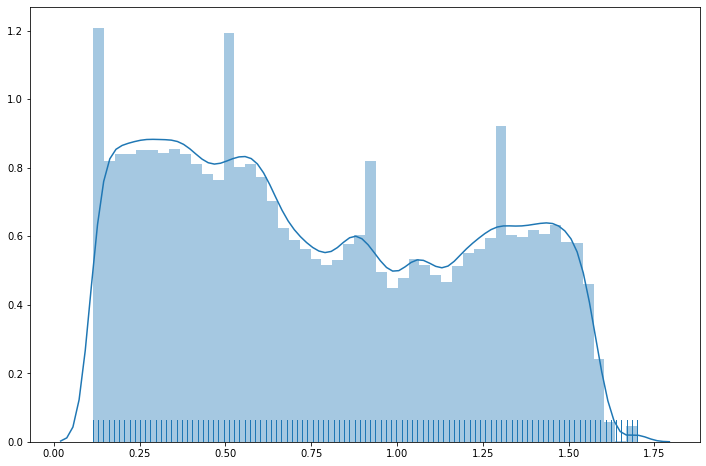

In [26]:
bg_th = 0.1
intensities = get_intensities('Pneumonia', bg_th)
sns.distplot(intensities, rug=True)

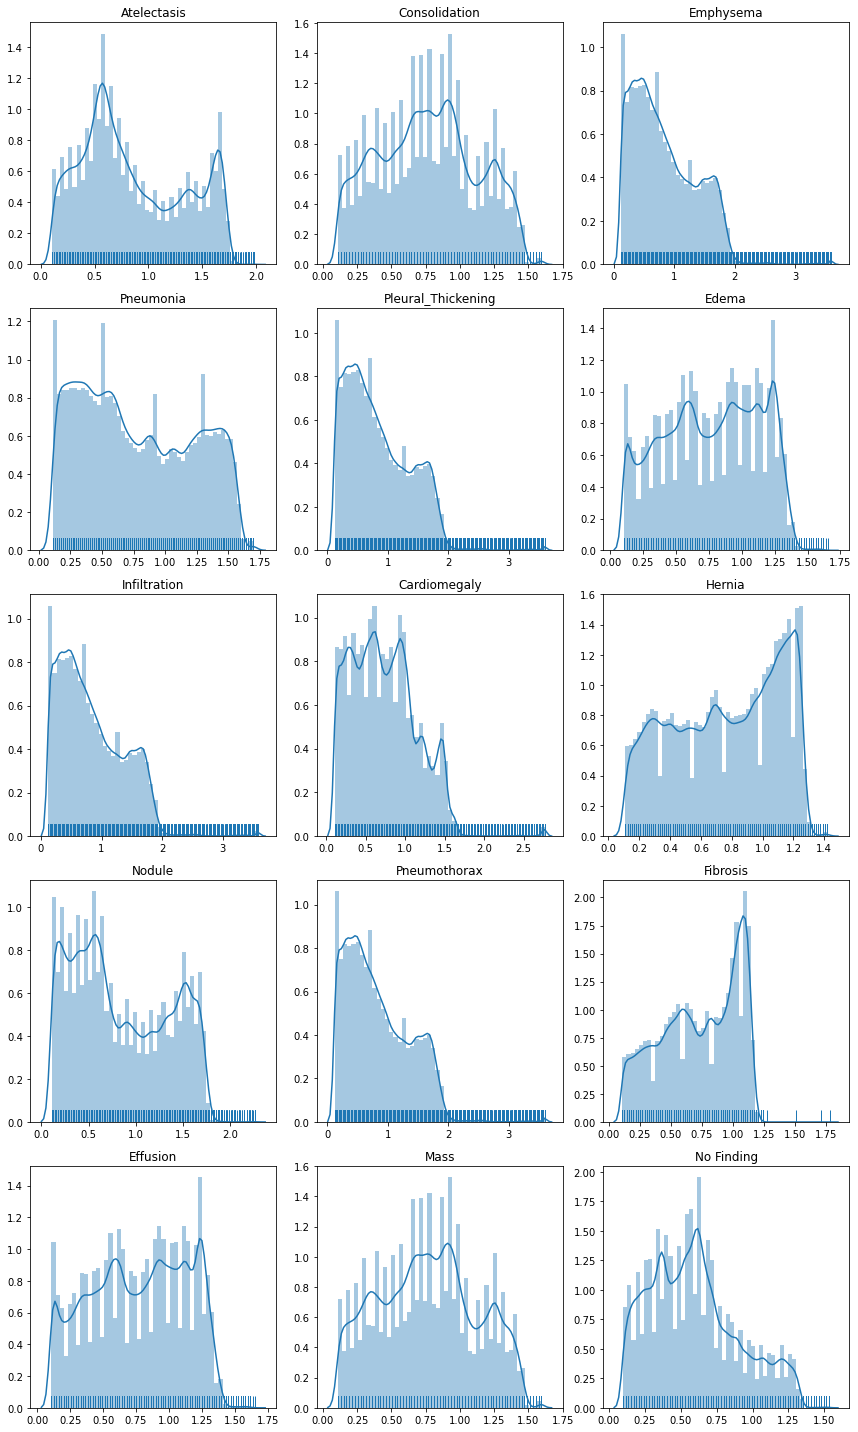

In [27]:
f = plt.figure(figsize=(12,20))
bg_th = 0.1
for i,finding in enumerate(labels):
    intensities = get_intensities(finding, bg_th)
    ax = f.add_subplot(5, 3, i+1)
    ax.set_title(finding)
    sns.distplot(intensities, rug=True)
plt.tight_layout()

## Normalized intensity distribution of some diseases label appears to be similar, which indicates their X-ray image is similar

 - Infiltration, Pleural_Thickening, Pneumothorax, Emphysema
 - Effusion, Edema
 - Consolidation, Mass
 
Furthermore, we also observe a significant overlap between the intensity distribution of pneumonia images and the infiltration group at the left peak, making diagnosis solely reliant on intensity distribution differences challenging. When these diseases exhibit similar intensity characteristics, it may affect the effectiveness of machine learning models. Hence, we need to explore more powerful deep learning models to capture the unique textures, shapes, or patterns of pneumonia and its underlying patterns.
 

## Model Training Setup Conclusion

Based on the previous exploratory analysis, we found that the age of patients is mainly concentrated between 0-100, showing a normal distribution with a very small proportion of outliers. We will remove these unrealistic ages (400, 200) before training the model.

The ratio of males to females is 55% to 45%, and this slight imbalance will be replicated in the validation group to ensure that the evaluation results represent real-world scenarios well. The proportion of View Position (PA:AP=6:4) should also be maintained in the validation group.

The pneumonia diagnosis rate is very low, at only 3%. To ensure effective training of our model, we'll create a balanced dataset with an equal distribution of positive and negative examples in the training group. This approach aims to provide sufficient information to the model, preventing it from favoring any specific label during training.

Ideally, we'd maintain the same 3% ratio of positive cases in the validation group. However, due to the small number of positive cases, this might introduce significant bias when evaluating the model's performance. To mitigate this issue, we can consider adjusting the proportion of positive examples in the validation group accordingly. 

Admittedly, this adjustment may result in the validation group not accurately representing real-world data, posing a trade-off between bias and representation fidelity. However, it's a necessary step to ensure a fair evaluation of the model's performance despite the rarity of positive cases.